#Question 2: Hole Filling

##1- Loading the Image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(166, 187)


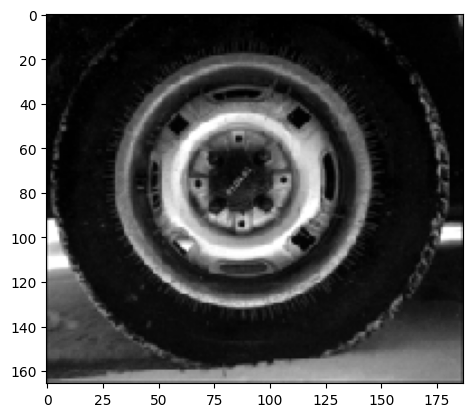

In [ ]:
from google.colab import drive
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Path to the image in Google Drive
image_file = '/content/drive/My Drive/Assignment-2/q2_wheel.png'

# Load the image
wheel = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

print(wheel.shape)
plt.imshow(wheel, cmap="gray")

##2- Hole Filling

Function described in the lectures for grayscale image hole filling consists of reconstruction of erosion of an itinal state with the original image we have.

For reconstruction of erosion to be implemented, first erosion function is implemented, which basicaly chooses the minimum value in the kernel.

In [ ]:
def grayscale_erosion(img, SE):

  # Assuming flat SE

  se_height, se_width = SE.shape
  img_height, img_width = img.shape

  row_pass = img_height - se_height + 1
  column_pass = img_width - se_width + 1

  # Calculations for padding
  lost_pixel_height = (se_height - 1)//2
  lost_pixel_width = (se_width - 1)//2
  eroded_img_np = [[255 for j in range(img_width)] for i in range(lost_pixel_height)]

  for i in range(row_pass):

    eroded_row = [255 for k in range(lost_pixel_width)] # padidng

    for j in range(column_pass):

      # Current window from the image
      patch = np.array([img[k][j:j + se_width] for k in range(i, i + se_height)])
      # Find the minimum and append it to the new matrix
      eroded_row.append(patch.min())

    # Pad and append the eroded row
    pad_from_left = [255 for k in range(lost_pixel_width)]
    eroded_row.extend(pad_from_left)
    eroded_img_np.append(eroded_row)

  # Padding
  pad_from_bottom = [[255 for j in range(img_width)] for i in range(lost_pixel_height)]
  eroded_img_np.extend(pad_from_bottom)

  # Returning the eroded and padded image in numpy form
  return np.array(eroded_img_np)

Example of erosion is given below:

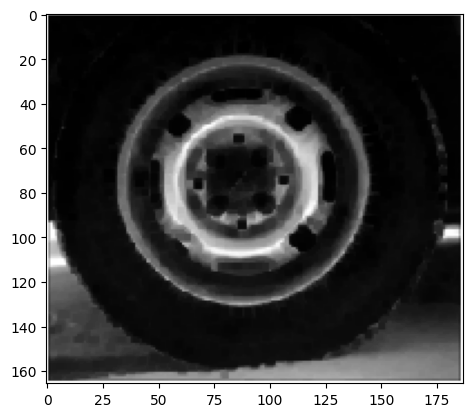

In [ ]:
SE = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

eroded_img = grayscale_erosion(wheel, SE)
plt.imshow(eroded_img, cmap="gray")

Reconstruction of erosion needs repeated steps of geodesic erosion.

Geodesic erosion's difference from a regular erosion is that geodesic erosion does not allow pixel values to be smaller than the original image. Thus, after the erosion, maximum among the image and the eroded version is taken for each pixel value.

In [ ]:
def geodesic_erosion(img, limit, SE):

  # Assumes that the img and limit have same shape

  # Calculating grayscale erosion
  eroded = grayscale_erosion(img, SE)

  row, col = img.shape

  returning = np.zeros(img.shape)

  for r in range(row):
    for c in range(col):

      # Compare for each pixel, whether the original value or the eroded value is larger
      returning[r, c] = max(eroded[r,c], limit[r,c])

  return returning


Hole filling algorithm uses a special initial state. The matrix at initial state is mainly consists of maximum value for a pixel, which is 255 in this case. However, only the edges of this matrix is same with the original image for algorithm to start.

The code below creates this initial matrix and shows the result of first step of reconstruction of erosion.

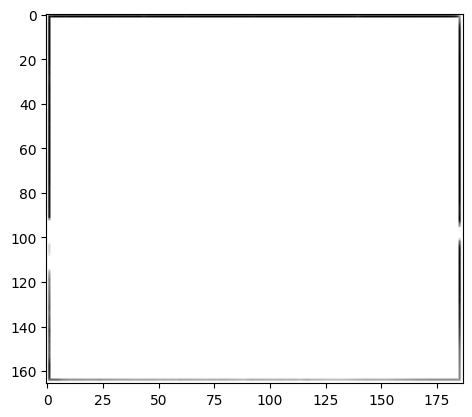

In [ ]:
initial = np.full(wheel.shape, wheel.max())

row, col = wheel.shape

for c in range(col):
  initial[0, c] = wheel[0, c]
  initial[row-1, c] = wheel[row-1, c]

for r in range(row):
  initial[r, 0] = wheel[r, 0]
  initial[r, col-1] = wheel[r, col-1]

geo_eroded_img = geodesic_erosion(initial, wheel, SE)
plt.imshow(geo_eroded_img, cmap="gray")

As stated, reconstruction of erosion repeats the geodesic erosion of the matrix with the original image. This repetition continues until there is no change occurs in the matrix. The function below applies this algorithm

In [ ]:
def reconstruction_by_erosion(img, limit, SE):

  #Assumes that the img and limit have same shape

  eroded = geodesic_erosion(img, limit, SE)
  prev = img

  # Repeat geodesic erosion until the matrix does not change anymore
  while not np.array_equal(prev, eroded):

    prev = np.copy(eroded)
    eroded = geodesic_erosion(eroded, limit, SE)

  return eroded

##3- Final Result

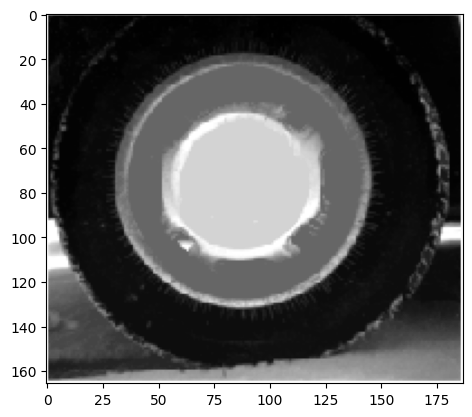

In [ ]:
filled = reconstruction_by_erosion(initial, wheel, SE)

plt.imshow(filled, cmap="gray")